In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/gplus/'

Mounted at /content/drive


In [2]:
import os

In [3]:
count = 0
qualified_users = []

for f in os.listdir(data_path):
    if f.endswith('.circles'):
        user_id = f.replace('.circles', '')
        edges_file = os.path.join(data_path, user_id + '.edges')
        circles_file = os.path.join(data_path, f)

        if os.path.exists(edges_file):
            with open(circles_file, 'r') as file:
                num_circles = sum(1 for _ in file)
                if num_circles > 2:
                    count += 1
                    qualified_users.append(user_id)

print(f"Number of personal networks for users with more than 2 circles: {count}")


Number of personal networks for users with more than 2 circles: 57


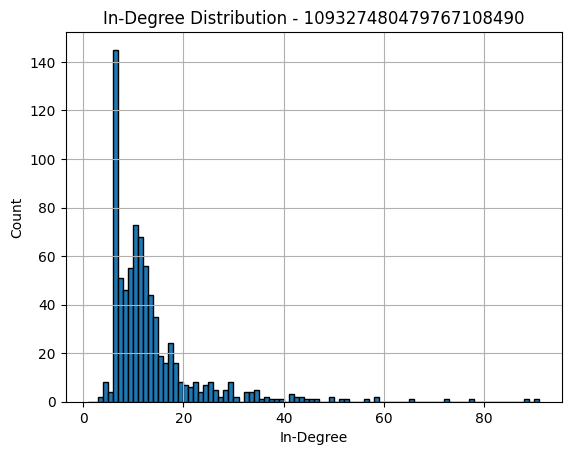

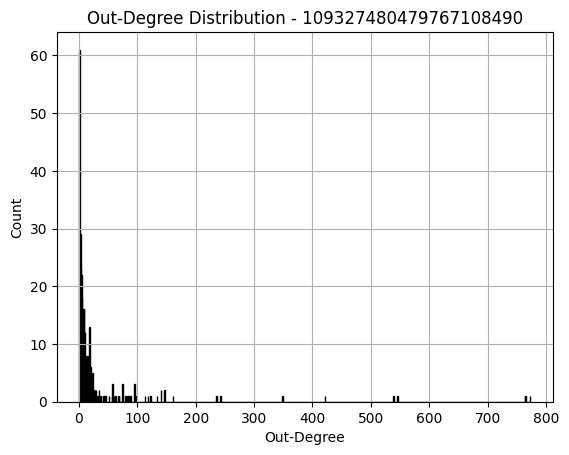

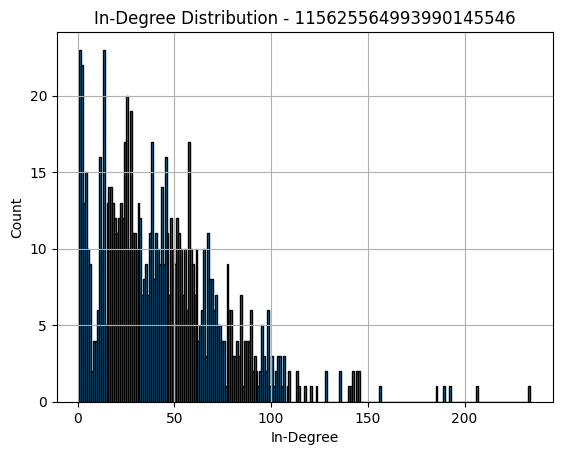

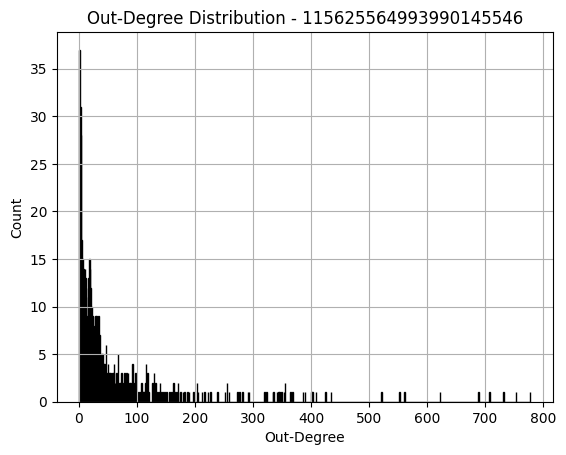

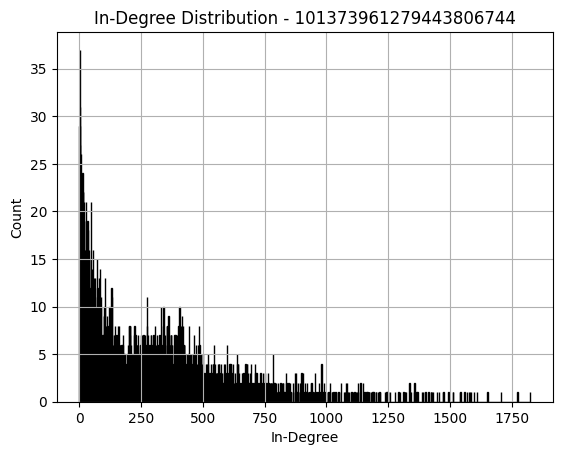

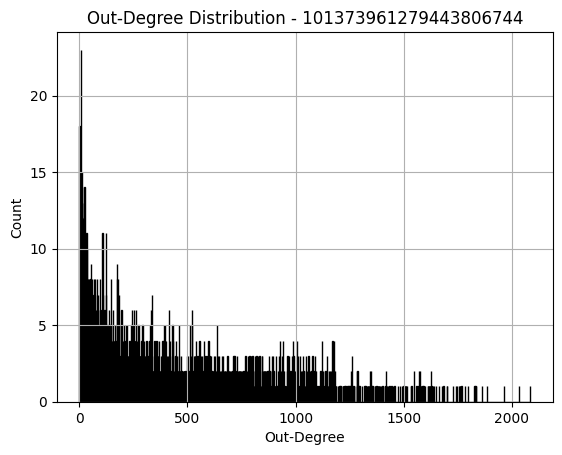

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# List of user IDs
user_ids = [
    '109327480479767108490',
    '115625564993990145546',
    '101373961279443806744'
]

def plot_degrees(user_id):
    file_path = os.path.join(data_path, f"{user_id}.edges")
    G = nx.read_edgelist(file_path, create_using=nx.DiGraph())

    in_degrees = [deg for _, deg in G.in_degree()]
    out_degrees = [deg for _, deg in G.out_degree()]

    # In-degree plot
    plt.figure()
    plt.hist(in_degrees, bins=range(1, max(in_degrees)+2), edgecolor='black')
    plt.title(f"In-Degree Distribution - {user_id}")
    plt.xlabel("In-Degree")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    # Out-degree plot
    plt.figure()
    plt.hist(out_degrees, bins=range(1, max(out_degrees)+2), edgecolor='black')
    plt.title(f"Out-Degree Distribution - {user_id}")
    plt.xlabel("Out-Degree")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Generate plots for all 3 users
for uid in user_ids:
    plot_degrees(uid)


In [5]:
import numpy as np
for uid in user_ids:
    file_path = os.path.join(data_path, f"{uid}.edges")
    G = nx.read_edgelist(file_path, create_using=nx.DiGraph())

    in_degrees = np.array([deg for _, deg in G.in_degree()])
    out_degrees = np.array([deg for _, deg in G.out_degree()])

    print(f"Node ID: {uid}")
    print(f"For the in-degree  : mean={in_degrees.mean():.3f}, Variance={in_degrees.var():.3f}")
    print(f"For the out-degree : mean={out_degrees.mean():.3f}, Variance={out_degrees.var():.3f}\n")


Node ID: 109327480479767108490
For the in-degree  : mean=13.080, Variance=95.745
For the out-degree : mean=13.080, Variance=3842.082

Node ID: 115625564993990145546
For the in-degree  : mean=42.687, Variance=1018.555
For the out-degree : mean=42.687, Variance=8512.612

Node ID: 101373961279443806744
For the in-degree  : mean=297.196, Variance=86385.462
For the out-degree : mean=297.196, Variance=162944.821



In [6]:
!pip install python-igraph cairocffi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00


Node ID: 109327480479767108490
  ➤ Number of communities: 4
  ➤ Modularity: 0.2798


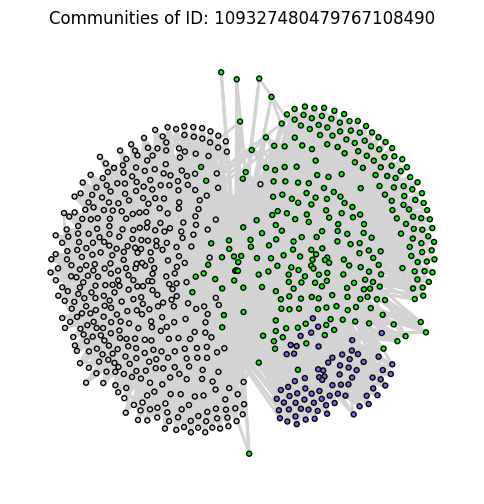

Node ID: 115625564993990145546
  ➤ Number of communities: 25
  ➤ Modularity: 0.3231


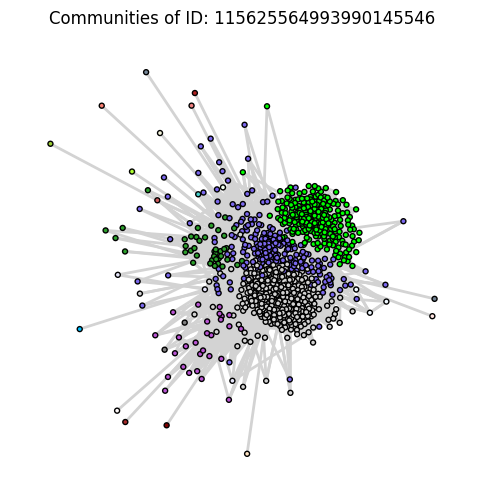

Node ID: 101373961279443806744
  ➤ Number of communities: 29
  ➤ Modularity: 0.1951


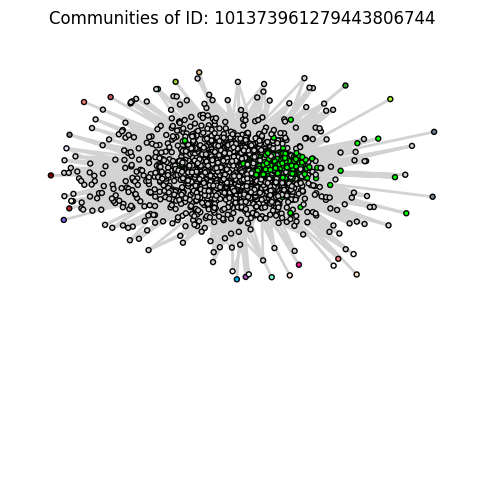

In [5]:
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

def load_graph_from_edges(file_path):
    # Read edges as string IDs
    df = pd.read_csv(file_path, sep=' ', header=None, dtype=str)
    edges = list(map(tuple, df.values.tolist()))

    # Create igraph with string vertex names
    G = ig.Graph(directed=False)
    vertices = set([v for edge in edges for v in edge])
    G.add_vertices(list(vertices))
    G.add_edges(edges)

    return G

# List of user IDs
interest_nodes = [
    '109327480479767108490',
    '115625564993990145546',
    '101373961279443806744'
]

data_path = '/content/drive/MyDrive/gplus/'

# Prepare nice colors
nice_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
random.shuffle(nice_colors)

for idx, uid in enumerate(interest_nodes):
    file_path = data_path + f"{uid}.edges"

    # Load graph from file
    G = load_graph_from_edges(file_path)

    # Run Walktrap
    walktrap = G.community_walktrap()
    communities = walktrap.as_clustering()

    # Print modularity
    print(f"Node ID: {uid}")
    print(f"  ➤ Number of communities: {len(communities)}")
    print(f"  ➤ Modularity: {communities.modularity:.4f}")

    # Assign colors to nodes
    G.vs["color"] = [nice_colors[communities.membership[v.index] % len(nice_colors)] for v in G.vs]

    # Plot each network separately
    layout = G.layout("fr")
    fig, ax = plt.subplots(figsize=(6, 6))
    ig.plot(
        G,
        target=ax,
        layout=layout,
        vertex_size=5,
        vertex_color=G.vs["color"],
        edge_color="lightgray",
        bbox=(400, 400),
        margin=20
    )
    plt.title(f"Communities of ID: {uid}")
    plt.show()


In [31]:
import pandas as pd
import math
from igraph import Graph

def compute_h_c_r_style_final(file_edges, file_circles, ego_id):
    # Load circles
    circles = []
    try:
        with open(file_circles, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) > 1:
                    circles.append(parts[1:])
    except FileNotFoundError:
        circles = []

    if len(circles) == 0:
        raise ValueError("No circles found.")

    # Read edges
    try:
        df = pd.read_csv(file_edges, sep=' ', header=None, names=["source", "target"], dtype=str)
        edge_nodes = set(df["source"]).union(set(df["target"]))
    except pd.errors.EmptyDataError:
        df = pd.DataFrame(columns=["source", "target"])
        edge_nodes = set()

    # Filter circle nodes: only keep nodes appearing in edges
    all_circle_nodes = sorted(list(set([n for c in circles for n in c if n != ego_id and n in edge_nodes])))
    N = len(all_circle_nodes)

    if N == 0:
        raise ValueError("No circle nodes found in edges.")

    # Calculate H(C)
    H_C = 0
    for circle in circles:
        valid_circle = [n for n in circle if n != ego_id and n in edge_nodes]
        a_i = len(valid_circle)
        if a_i > 0:
            H_C -= (a_i/N) * math.log10(a_i/N)

    # Build graph
    G = Graph(directed=True)
    all_nodes = sorted(list(edge_nodes.union({ego_id})))
    G.add_vertices(all_nodes)
    if not df.empty:
        G.add_edges(list(zip(df["source"], df["target"])))

    # Connect ego node to all valid circle nodes
    ego_index = G.vs.find(name=ego_id).index
    for n in all_circle_nodes:
        if n in G.vs['name']:
            G.add_edge(ego_index, G.vs.find(name=n).index)

    # Walktrap
    if G.ecount() > 0:
        communities = G.community_walktrap(steps=4).as_clustering()
        membership = communities.membership
    else:
        membership = [0]*len(G.vs)

    community_map = {G.vs[i]["name"]: membership[i] for i in range(len(G.vs))}

    # Calculate H(K), H(C|K), H(K|C)
    H_K = 0
    H_C_K = 0
    H_K_C = 0

    community_ids = set(membership)

    for m in community_ids:
        community_nodes = [G.vs[i]["name"] for i in range(len(G.vs)) if membership[i] == m]
        b_i = len(set(community_nodes).intersection(set(all_circle_nodes)))

        if b_i > 0:
            H_K -= (b_i/N) * math.log10(b_i/N)
            for circle in circles:
                valid_circle = [n for n in circle if n != ego_id and n in edge_nodes]
                A_i = len(valid_circle)
                c_ij = len(set(community_nodes).intersection(set(valid_circle)))

                if c_ij > 0:
                    H_C_K -= (c_ij/N) * math.log10(c_ij/b_i)
                    H_K_C -= (c_ij/N) * math.log10(c_ij/A_i)

    homogeneity = 1 - (H_C_K/H_C) if H_C != 0 else 0
    completeness = 1 - (H_K_C/H_K) if H_K != 0 else 0
    v_measure = 2 * homogeneity * completeness / (homogeneity + completeness) if (homogeneity + completeness) > 0 else 0

    return {
        "node_id": ego_id,
        "H_C": H_C,
        "H_K": H_K,
        "H_C_K": H_C_K,
        "H_K_C": H_K_C,
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "num_circles": len(circles),
        "num_communities": len(community_ids),
        "num_nodes": N
    }

node_ids = [
    "109327480479767108490",
    "115625564993990145546",
    "101373961279443806744"
]

data_path = '/content/drive/MyDrive/gplus/'

for node_id in node_ids:
    res = compute_h_c_r_style_final(
        f"{data_path}{node_id}.edges",
        f"{data_path}{node_id}.circles",
        node_id
    )

    print("\n" + "**"*75)
    print(f"Node ID: {node_id}")
    print(f"Entropy H(C) = {res['H_C']:.8f}")
    print(f"Entropy H(K) = {res['H_K']:.8f}")
    print(f"Conditional Entropy H(C|K) = {res['H_C_K']:.8f}")
    print(f"Conditional Entropy H(K|C) = {res['H_K_C']:.8f}")
    print(f"Homogeneity h= {res['homogeneity']:.8f}")
    print(f"Completeness c= {res['completeness']:.8f}")
    print(f"V-measure V= {res['v_measure']:.8f}")



******************************************************************************************************************************************************
Node ID: 109327480479767108490
Entropy H(C) = 0.45634767
Entropy H(K) = 0.43655637
Conditional Entropy H(C|K) = 0.06759188
Conditional Entropy H(K|C) = 0.29254781
Homogeneity h= 0.85188512
Completeness c= 0.32987391
V-measure V= 0.47558710

******************************************************************************************************************************************************
Node ID: 115625564993990145546
Entropy H(C) = 3.67636649
Entropy H(K) = 0.47975860
Conditional Entropy H(C|K) = 2.05036616
Conditional Entropy H(K|C) = 2.33866572
Homogeneity h= 0.44228461
Completeness c= -3.87467181
V-measure V= 0.00000000

******************************************************************************************************************************************************
Node ID: 101373961279443806744
Entropy H(C) = 0.16690804
Entrop